<a href="https://colab.research.google.com/github/luca-arts/seeingtheimperceptible/blob/main/notebooks/sensorDustRemoval/tests/sensorDustRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Sensor Dust Detection and Inpainting

![](https://media.giphy.com/media/xUPJPtw7LRAmTZ60rS/giphy.gif)

Based on [Tschucker](https://github.com/Tschucker/Python-Automatic-Sensor-Dust-Removal)


In [ ]:
#@title imports of libraries
#import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os, sys
!curl https://raw.githubusercontent.com/Tschucker/Python-Automatic-Sensor-Dust-Removal/main/shapedetector.py -o /content/shapedetector.py
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
from shapedetector import ShapeDetector
import imutils
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1255  100  1255    0     0  26702      0 --:--:-- --:--:-- --:--:-- 26702


In [ ]:
#@title link the dataset from next-cloud
!curl https://raw.githubusercontent.com/luca-arts/seeingtheimperceptible/main/notebooks/database_mod.py -o /content/database_mod.py

from database_mod import *

link_nextcloud()

nextcloud = '/content/database/'

input_folder, output_folder = create_io(database=nextcloud,topic='sensorDustRemoval',library='openCV')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2235  100  2235    0     0  14703      0 --:--:-- --:--:-- --:--:-- 14703
what's the username for nextcloud? colab
what's the password for user colab? ··········
1
Please enter the username to authenticate with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Username: Please enter the password to authenticate user colab with server
https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ or hit enter for none.
  Password:  
content of /etc/fstab: https://cloud.bxlab.net/remote.php/dav/files/colab/colabfiles/ /content/database davfs user,rw,auto 0 0


## choose image for inpainting

In [ ]:
image_number = 5 #@param {type:"slider", min:0,max:10, step:1}
img_path = os.path.join(input_folder,os.listdir(input_folder)[image_number])
img_name = img_path.split('/')[-1].split('.')[0]
print(img_path, img_name)

#color version
cimg = cv2.imread(img_path)
#grey scale image
img = cv2.imread(img_path,0)

/content/database/sensorDustRemoval/input/LB_0006.jpg LB_0006


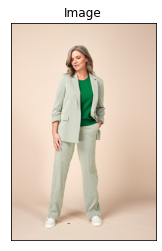

In [ ]:
#@title Show and Save Original Color Image
cv2.imwrite('original_image.png', cimg)

plt_image = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)
plt.imshow(plt_image)
plt.title('Image'), plt.xticks([]), plt.yticks([])
plt.show()

## TL;DR part

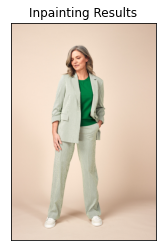

In [ ]:
#@title Set inpainting options and plot result
radius = 10 #@param {type:"slider",min:1, max:50}
flags = cv2.INPAINT_TELEA #@param ["cv2.INPAINT_TELEA","cv2.INPAINT_NS"]

def inpaint_img(img, img_name, radius=10, flags=cv2.INPAINT_TELEA):
  #Apply Global Threshold
  m = np.mean(img, dtype=int)
  global_thresh = cv2.threshold(img,int(m/1.2),255,cv2.THRESH_BINARY_INV)[1]

  #Perform Adaptive Threshold
  adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,10)

  #Image Magnification Filter Kernel
  KERNEL = np.ones((10,10), dtype=int)*10

  #Filter the thresholded images*
  img_filt = cv2.filter2D(adaptive_thresh_img,-1,KERNEL)
  #global_thresh = cv2.filter2D(global_thresh,-1,KERNEL)

  #Apply multiple times
  for i in range(2):
      KERNEL_i = np.ones((int(10),int(10)), dtype=int)*10
      img_filt = cv2.filter2D(img_filt,-1,KERNEL_i)

  #Combine Thresholds
  comb = img_filt + global_thresh

  #Find and Classify Contours of Image
  cnts = cv2.findContours(comb.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  sd = ShapeDetector()
  cimg_copy = cimg.copy()
  for c in cnts:
      # compute the center of the contour, then detect the name of the
      # shape using only the contour
      M = cv2.moments(c)
      if M["m00"] != 0:
          cX = int((M["m10"] / M["m00"]) * 1)
          cY = int((M["m01"] / M["m00"]) * 1)
          shape = sd.detect(c)
          # multiply the contour (x, y)-coordinates by the resize ratio,
          # then draw the contours and the name of the shape on the image
          if len(c) < 50:
              c = c.astype("float")
              c *= 1
              c = c.astype("int")
              cv2.drawContours(cimg_copy, [c], -1, (0, 255, 0), 2)
              cv2.putText(cimg_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)
  
  #Create Dust Mask
  img_mask = np.zeros((img.shape[0], img.shape[1]), dtype='uint8')
  for c in cnts:
      # compute the center of the contour, then detect the name of the
      # shape using only the contour
      M = cv2.moments(c)
      if M["m00"] != 0:
          cX = int((M["m10"] / M["m00"]) * 1)
          cY = int((M["m01"] / M["m00"]) * 1)
          shape = sd.detect(c)
          # multiply the contour (x, y)-coordinates by the resize ratio,
          # then draw the contours and the name of the shape on the image
          if len(c) < 50:
              c = c.astype("float")
              c *= 1
              c = c.astype("int")
              cv2.fillPoly(img_mask, pts=[c], color=(255,255,255))

    
  #Inpaint the image
  cimg_inpaint = cv2.inpaint(cimg, img_mask, radius, flags=flags)

    #Show and Save Final Image
  cv2.imwrite(os.path.join(output_folder,img_name,".png"), cimg_inpaint)

  plt_out = cv2.cvtColor(cimg_inpaint, cv2.COLOR_BGR2RGB)
  plt.imshow(plt_out)
  plt.title('Inpainting Results'), plt.xticks([]), plt.yticks([])
  plt.show()

inpaint_img(img, img_name, radius=radius, flags=flags)

## If you want to see the entire process, look further

## Apply Thresholds to the Image

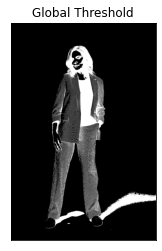

In [ ]:
#Apply Global Threshold
m = np.mean(img, dtype=int)
global_thresh = cv2.threshold(img,int(m/1.2),255,cv2.THRESH_BINARY_INV)[1]

#Show and Save Global Threshold Image
cv2.imwrite('global_threshold.png', global_thresh) 

plt.imshow(global_thresh, 'gray')
plt.title('Global Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

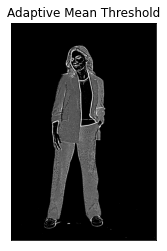

In [ ]:
#Perform Adaptive Threshold
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,27,15)
adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,19,10)
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,5)
#adaptive_thresh_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,5,2)


#Show and Save Adaptive Threshold Image
cv2.imwrite('adapt_mean_threshold.png', adaptive_thresh_img)  

plt.imshow(adaptive_thresh_img, 'gray')
plt.title('Adaptive Mean Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

## Filter the Thresholded Image with Magnification Filter

In [ ]:
#Image Magnification Filter Kernel
KERNEL = np.ones((10,10), dtype=int)*10

print(KERNEL)

[[10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10]]


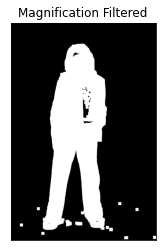

In [ ]:
#Filter the thresholded images*
img_filt = cv2.filter2D(adaptive_thresh_img,-1,KERNEL)
#global_thresh = cv2.filter2D(global_thresh,-1,KERNEL)

#Apply multiple times
for i in range(2):
    KERNEL_i = np.ones((int(10),int(10)), dtype=int)*10
    img_filt = cv2.filter2D(img_filt,-1,KERNEL_i)

#Show and Save Magnification Image
cv2.imwrite('mag_filt.png', img_filt)    

plt.imshow(img_filt, 'gray')
plt.title('Magnification Filtered'), plt.xticks([]), plt.yticks([])
plt.show()

## Combine the Thresholds Together

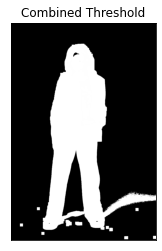

In [ ]:
#Combine Thresholds
comb = img_filt + global_thresh

#Show and Save Combined Threshold Image
cv2.imwrite('comb_threshold.png', comb)

plt.imshow(comb, 'gray')
plt.title('Combined Threshold'), plt.xticks([]), plt.yticks([])
plt.show()

## Find and Classify the Contours in the Image


In [ ]:
#Find and Classify Contours of Image
cnts = cv2.findContours(comb.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
sd = ShapeDetector()

cimg_copy = cimg.copy()

for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int((M["m10"] / M["m00"]) * 1)
        cY = int((M["m01"] / M["m00"]) * 1)
        shape = sd.detect(c)
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape on the image
        if len(c) < 50:
            c = c.astype("float")
            c *= 1
            c = c.astype("int")
            cv2.drawContours(cimg_copy, [c], -1, (0, 255, 0), 2)
            cv2.putText(cimg_copy, shape, (cX, cY), cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 255, 255), 2)

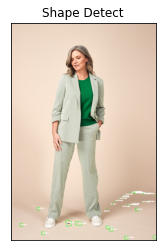

In [ ]:
#Show and Save Detected Contours
cv2.imwrite('shape_detect.png', cimg_copy)

plt_cimage = cv2.cvtColor(cimg_copy, cv2.COLOR_BGR2RGB)
plt.imshow(plt_cimage)
plt.title('Shape Detect'), plt.xticks([]), plt.yticks([])
plt.show()

## Create the Inpainting Mask based on the Detected Contours

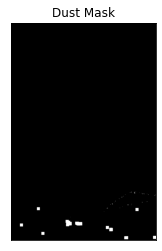

In [ ]:
#Create Dust Mask
img_mask = np.zeros((img.shape[0], img.shape[1]), dtype='uint8')
for c in cnts:
    # compute the center of the contour, then detect the name of the
    # shape using only the contour
    M = cv2.moments(c)
    if M["m00"] != 0:
        cX = int((M["m10"] / M["m00"]) * 1)
        cY = int((M["m01"] / M["m00"]) * 1)
        shape = sd.detect(c)
        # multiply the contour (x, y)-coordinates by the resize ratio,
        # then draw the contours and the name of the shape on the image
        if len(c) < 50:
            c = c.astype("float")
            c *= 1
            c = c.astype("int")
            cv2.fillPoly(img_mask, pts=[c], color=(255,255,255))

#Show and Save Mask Image
cv2.imwrite('dust_mask.png', img_mask)
plt.imshow(img_mask, 'gray')
plt.title('Dust Mask'), plt.xticks([]), plt.yticks([])
plt.show()

## Perform Inpainting

In [ ]:
#Set inpainting options
radius = 10
flags = cv2.INPAINT_TELEA #or use cv2.INPAINT_NS

In [ ]:
#Inpaint the image
cimg_inpaint = cv2.inpaint(cimg, img_mask, radius, flags=flags)

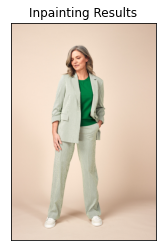

In [ ]:
#Show and Save Final Image
cv2.imwrite('auto_dust_inpainting.png', cimg_inpaint)

plt_out = cv2.cvtColor(cimg_inpaint, cv2.COLOR_BGR2RGB)
plt.imshow(plt_out)
plt.title('Inpainting Results'), plt.xticks([]), plt.yticks([])
plt.show()